In [2]:
import os
os.chdir('../')

In [3]:
import gym
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import torch

from custom_envs import *
from movies.env_enum import EnvEnum

/Users/prozwood/Desktop/Work/koopman-rl-root/koopman-cleanrl/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class Args:
    def __init__(
        self,
        seed=123,
        data_folder=True,
        save_every_n_steps=None,
        plot_uncontrolled=False,
        ma_window_size=None,
    ):
        self.seed = seed
        self.data_folder = data_folder
        self.save_every_n_steps = save_every_n_steps
        self.plot_uncontrolled = plot_uncontrolled
        self.ma_window_size = ma_window_size

In [5]:
args = Args(
    seed=123,

    data_folder="./video_frames/LinearSystem-v0_1732073403",

    # data_folder="./video_frames/LinearSystem-v0_1730942805",
    # data_folder="./video_frames/FluidFlow-v0_1730942657",
    # data_folder="./video_frames/Lorenz-v0_1731380184",
    # data_folder="./video_frames/DoubleWell-v0_1730941860",

    save_every_n_steps=100,

    # plot_uncontrolled=False,
    plot_uncontrolled=True,

    ma_window_size=20,
    # ma_window_size=200,
)

In [6]:
# Helper function to create environments
def make_env(env_id, seed):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

In [7]:
# Load main policy data
main_policy_trajectories = np.load(f"{args.data_folder}/main_policy_trajectories.npy")
main_policy_costs = np.load(f"{args.data_folder}/main_policy_costs.npy")

# Load baseline policy data
baseline_policy_trajectories = np.load(f"{args.data_folder}/baseline_policy_trajectories.npy")
baseline_policy_costs = np.load(f"{args.data_folder}/baseline_policy_costs.npy")

#  Load zero policy data
if args.plot_uncontrolled:
    zero_policy_trajectories = np.load(f"{args.data_folder}/zero_policy_trajectories.npy")
    zero_policy_costs = np.load(f"{args.data_folder}/zero_policy_costs.npy")

# Load metadata
metadata = np.load(f"{args.data_folder}/metadata.npy", allow_pickle=True).item()

# Extract env_id
env_id = metadata['env_id']

# Function to reset seeds
def reset_seed():
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

# Set seeds
reset_seed()

# Create gym env with ID
envs = gym.vector.SyncVectorEnv([make_env(metadata['env_id'], args.seed)])

max eigen factor: 0.9089407556793585
A:
[[0.34434946 0.22516541 0.36478571]
 [0.22516541 0.14881789 0.23481312]
 [0.36478571 0.23481312 0.45749926]]
A's max absolute real eigenvalue: 0.9089407556793585


/Users/prozwood/Desktop/Work/koopman-rl-root/koopman-cleanrl/venv/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [8]:
print(f"Main policy trajectories shape: {main_policy_trajectories.shape}")
print(f"Baseline policy trajectories shape: {baseline_policy_trajectories.shape}")
if args.plot_uncontrolled:
    print(f"Zero policy trajectories shape: {zero_policy_trajectories.shape}")

Main policy trajectories shape: (1, 200, 3)
Baseline policy trajectories shape: (1, 200, 3)
Zero policy trajectories shape: (1, 200, 3)


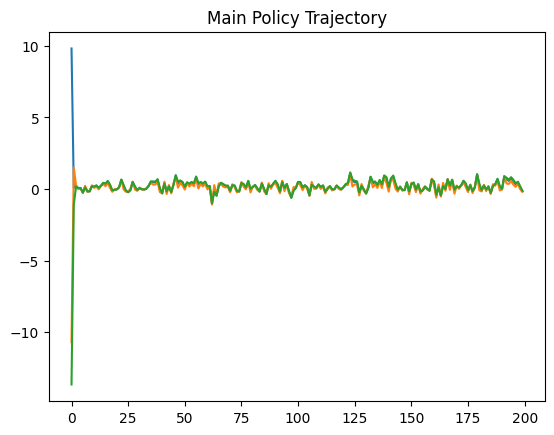

In [9]:
plt.title("Main Policy Trajectory")
plt.plot(main_policy_trajectories[0])
plt.show()

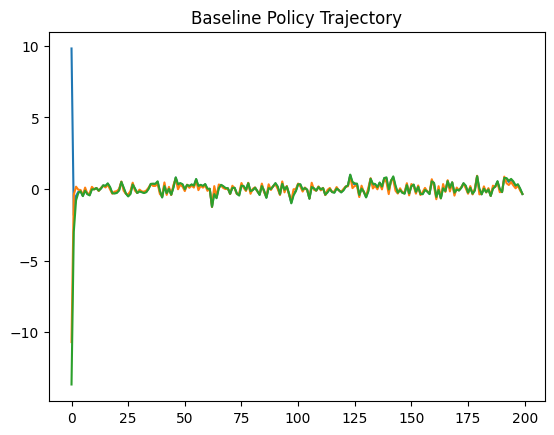

In [10]:
plt.title("Baseline Policy Trajectory")
plt.plot(baseline_policy_trajectories[0])
plt.show()

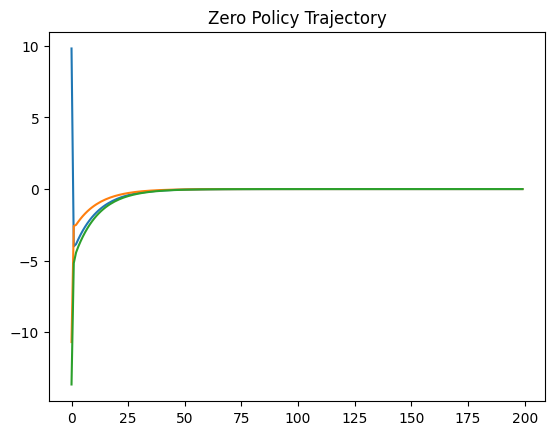

In [11]:
if args.plot_uncontrolled:
    plt.title("Zero Policy Trajectory")
    plt.plot(zero_policy_trajectories[0])
    plt.show()

In [12]:
# Function to compute moving average, preserving the first n values
def moving_average(a, n, keep_first):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n

    # If `keep_first` is True, concatenate the first n-1 values of the original array
    if keep_first:
        result = np.concatenate((a[:n - 1], moving_avg))
        print(result.shape)
    else:
        result = moving_avg

    return result

In [19]:
assert (
    np.array_equal(main_policy_trajectories[0, 0], baseline_policy_trajectories[0, 0]) and
    np.array_equal(main_policy_trajectories[0, 0], zero_policy_trajectories[0, 0])
), "Your trajectories have different initial conditions"

/var/folders/fd/l0yckynn6ls7k7r_vn2yzy340000gn/T/ipykernel_15735/3999231319.py:92: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


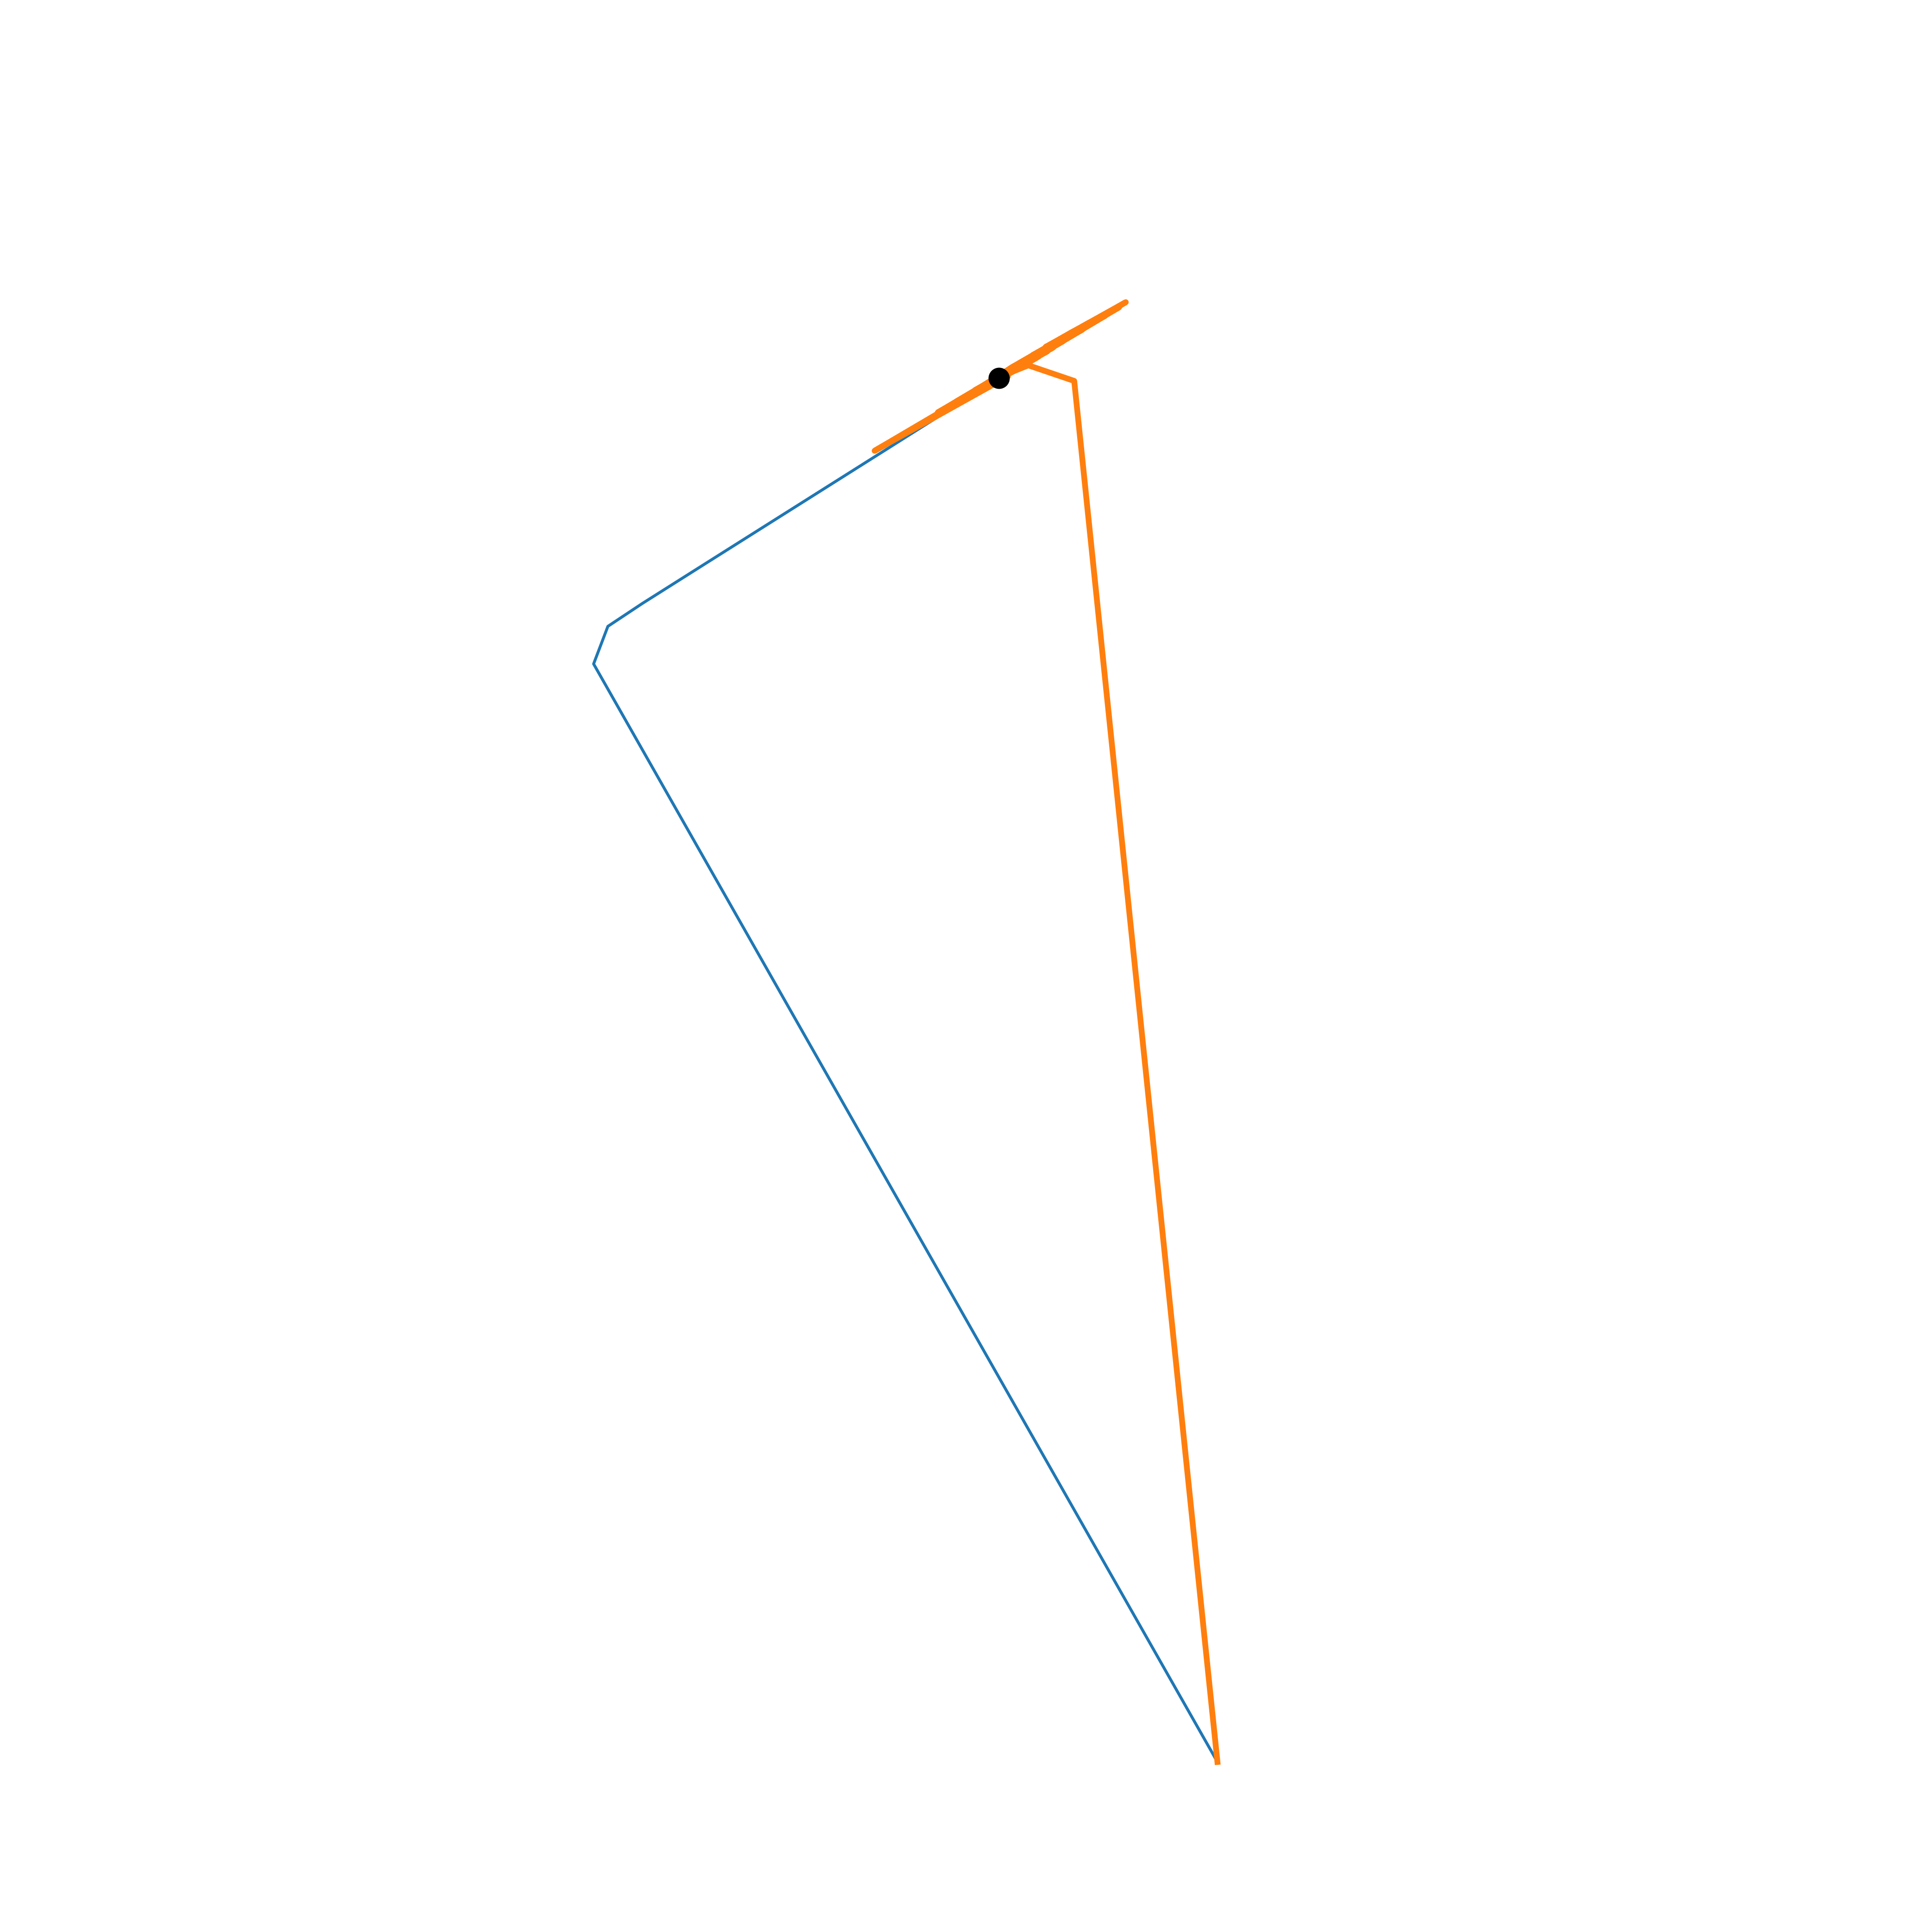

In [117]:
# Extract x, y, and z components from the trajectory data
full_x = main_policy_trajectories[0, :, 0]
full_y = main_policy_trajectories[0, :, 1]
full_z = main_policy_trajectories[0, :, 2]
if args.plot_uncontrolled:
    full_x_zero = zero_policy_trajectories[0, :, 0]
    full_y_zero = zero_policy_trajectories[0, :, 1]
    full_z_zero = zero_policy_trajectories[0, :, 2]

# In this notebook, we avoid looping to make this easier
x = full_x
y = full_y
z = full_z
if args.plot_uncontrolled:
    x_zero = full_x_zero
    y_zero = full_y_zero
    z_zero = full_z_zero

# Create trajectory figure
# trajectory_fig = plt.figure()
trajectory_fig = plt.figure(figsize=(21, 14), dpi=300, constrained_layout=True)
trajectory_ax = trajectory_fig.add_subplot(111, projection='3d')

# If we want to do a mesh for the uncontrolled dynamics,
# we need to create a meshgrid and we would need to pass
# it through the dynamics function for all possible X,Y pairs

# Place Green dot at the reference point as determined from the environment with zorder smaller than all other objects
trajectory_ax.scatter(
    envs.envs[0].reference_point[0],
    envs.envs[0].reference_point[1],
    envs.envs[0].reference_point[2],
    color='black',
    s=100,
    zorder=1
)

# Set axis limits according to the trajectory limits, using zero_policy only if plot_uncontrolled is True
if args.plot_uncontrolled:
    # Maximums
    max_x = np.max([np.max(full_x), np.max(full_x_zero)])
    max_y = np.max([np.max(full_y), np.max(full_y_zero)])
    max_z = np.max([np.max(full_z), np.max(full_z_zero)])
    # Minimums
    min_x = np.min([np.min(full_x), np.min(full_x_zero)])
    min_y = np.min([np.min(full_y), np.min(full_y_zero)])
    min_z = np.min([np.min(full_z), np.min(full_z_zero)])
else:
    # Maximums
    max_x = np.max(full_x)
    max_y = np.max(full_y)
    max_z = np.max(full_z)
    # Minimums
    min_x = np.min(full_x)
    min_y = np.min(full_y)
    min_z = np.min(full_z)

trajectory_ax.set_xlim(min_x, max_x)
trajectory_ax.set_ylim(min_y, max_y)
if not env_id == EnvEnum.DoubleWell:
    if env_id == EnvEnum.Lorenz:
        trajectory_ax.set_zlim(min_z * 2, max_z * 0.8)
    else:
        trajectory_ax.set_zlim(min_z, max_z)

# Plot trajectory
if env_id == EnvEnum.DoubleWell:
    pass  # TODO: Get double well working for this notebook

    # trajectory_ax.plot3D(x, y, Z_path, alpha=1.0, linewidth=2, color='black', pad=0.1)
    # trajectory_ax.plot_surface(X, Y, Z, alpha=0.7, cmap=cm.coolwarm)
    # trajectory_ax.set_zlim(0,15)
else:
    # Plot
    if args.plot_uncontrolled:
        # Plot the zero trajectory on the same graph
        trajectory_ax.plot3D(x_zero, y_zero, z_zero, color='tab:blue', zorder=2)
    trajectory_ax.plot3D(x, y, z, linewidth=3, color='tab:orange', zorder=2)

    # Adjust the view angle for better visibility
    # trajectory_ax.view_init(elev=20, azim=45)

    # Adjust layout to reduce white space
    # plt.tight_layout(pad=0.01)

    # Turn off grid
    trajectory_ax.grid(False)

    # Turn off axis
    trajectory_ax.set_axis_off()

plt.tight_layout()
plt.show()

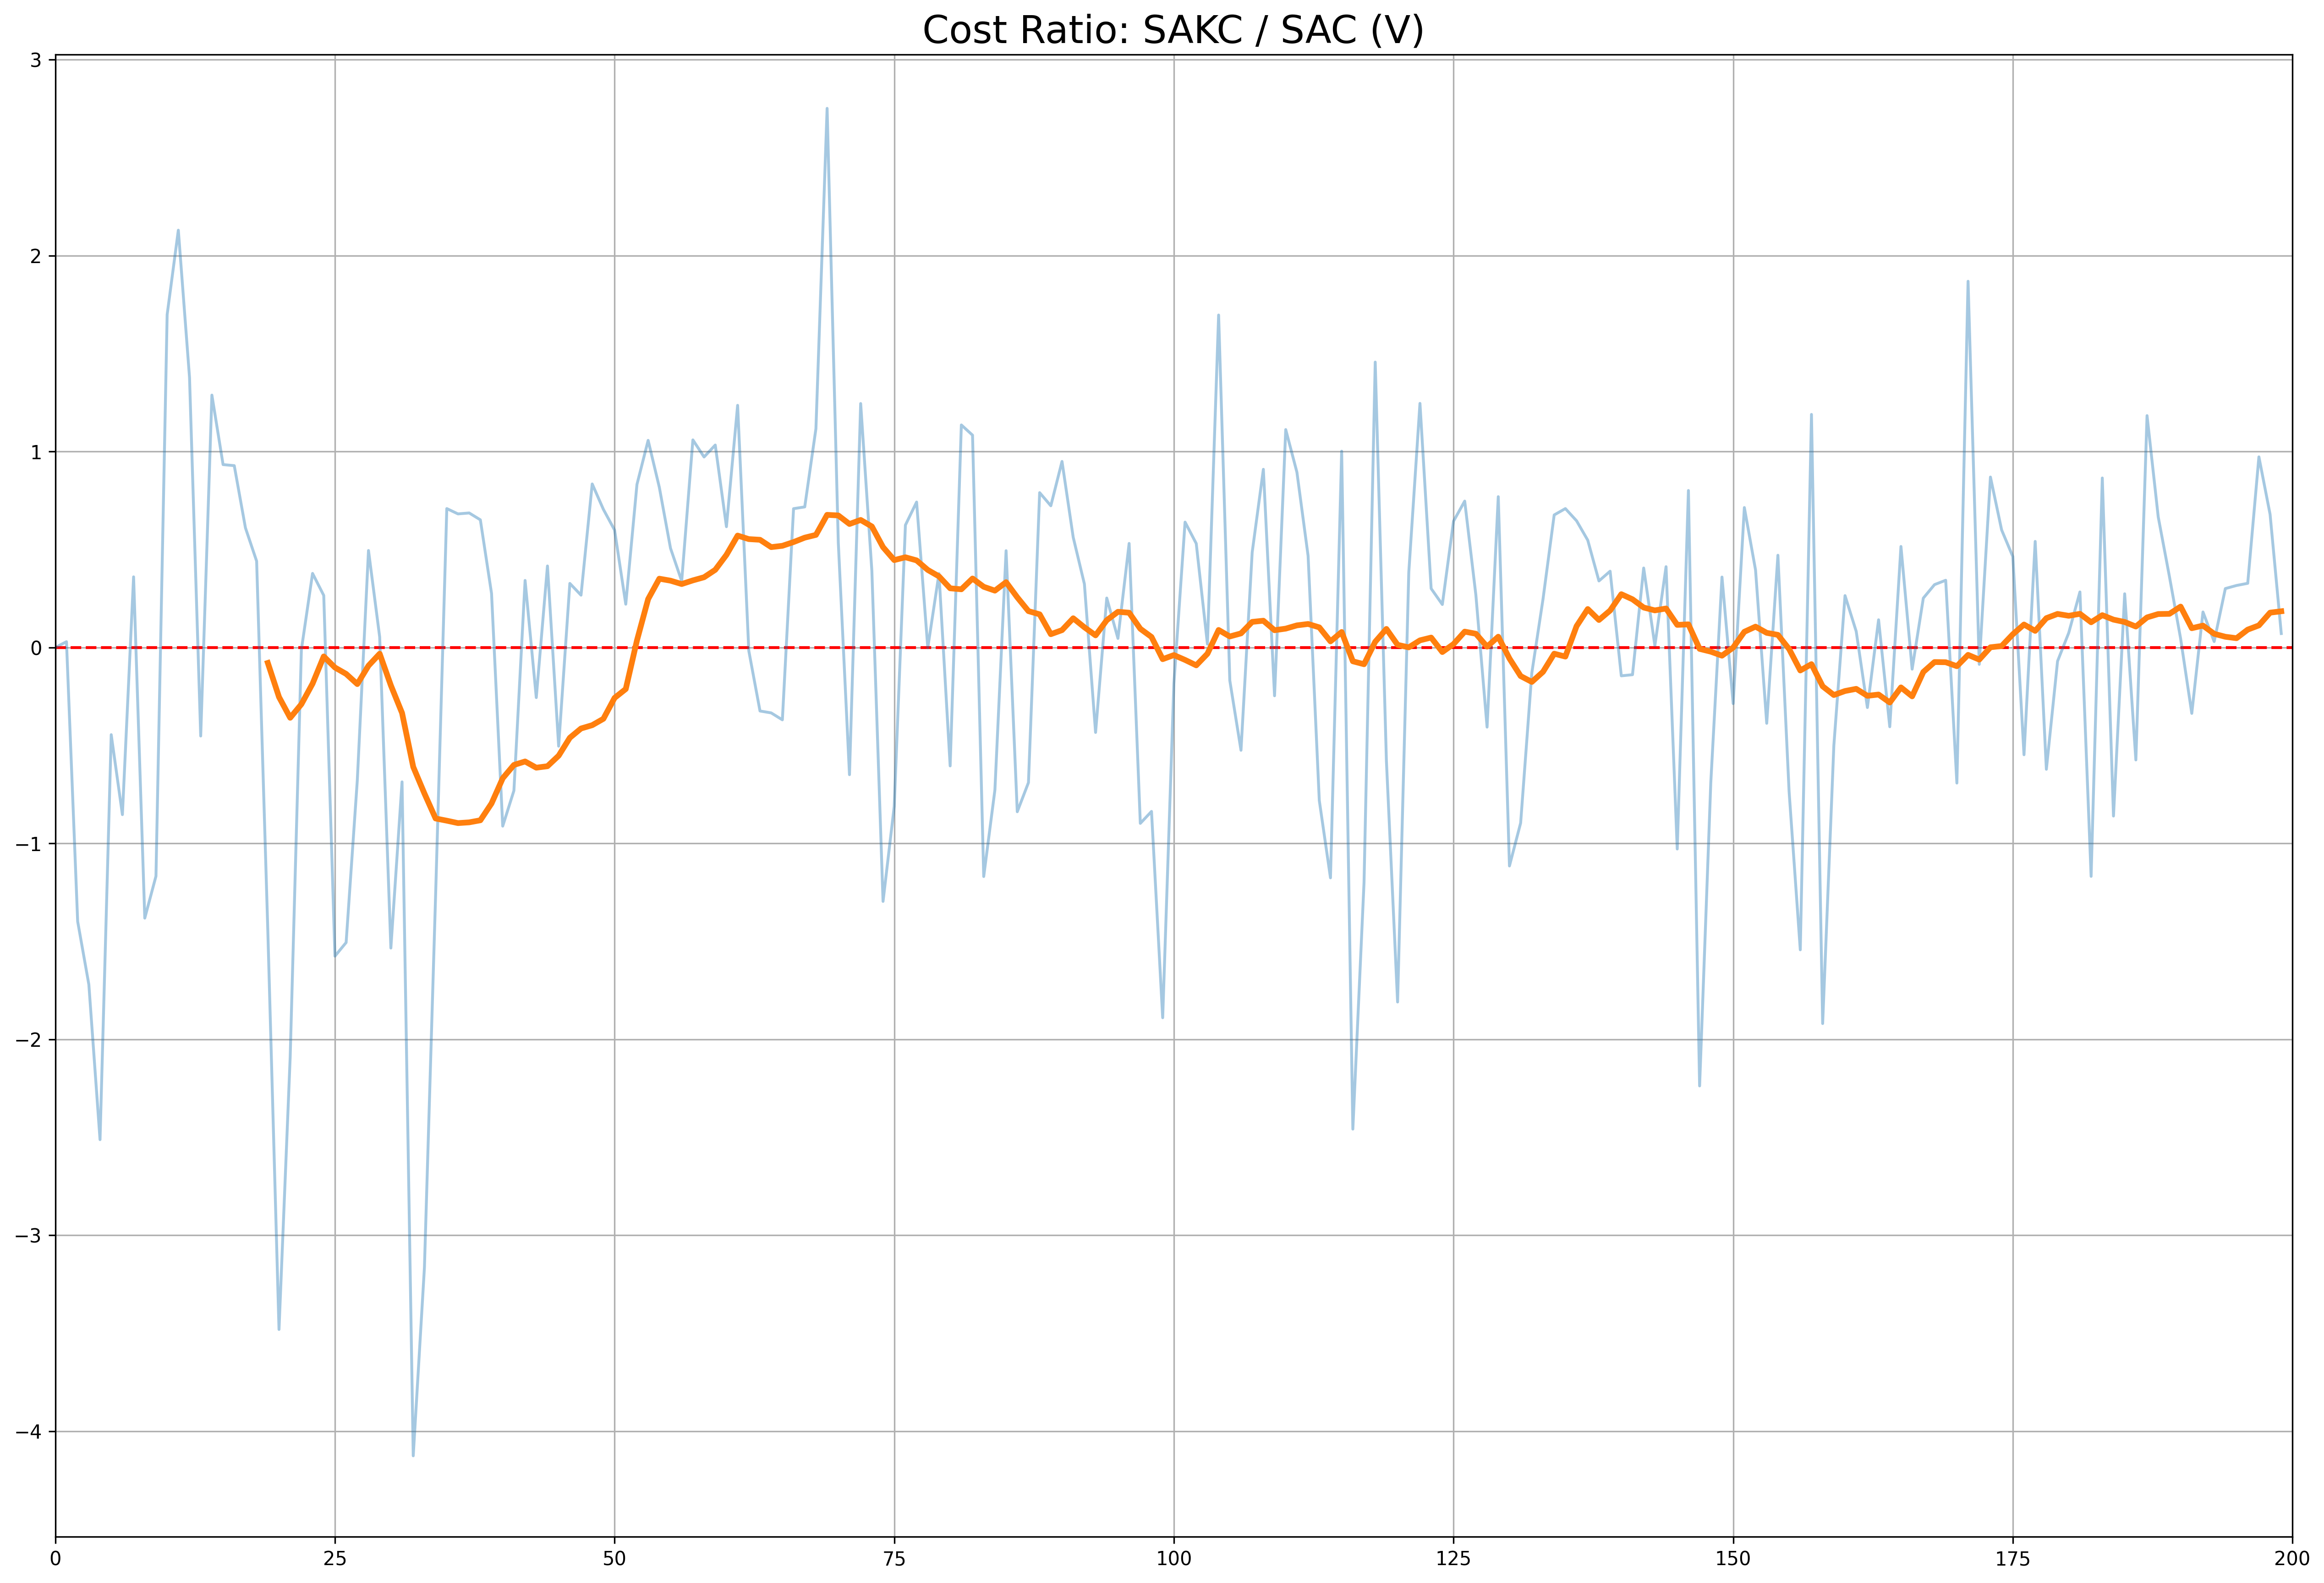

In [118]:
# Create cost figure
cost_fig = plt.figure(figsize=(21, 14), dpi=300)
cost_ax = cost_fig.add_subplot(111)
cost_ax.set_ylabel('')  # Removes the y-axis label on a specific axis

# Calculate the cost ratios for this iteration
all_main_costs = main_policy_costs[0]
all_baseline_costs = baseline_policy_costs[0]
all_cost_ratios = all_main_costs / all_baseline_costs
log_all_cost_ratios = np.log(all_main_costs / all_baseline_costs)
moving_average_log_all_cost_ratios = moving_average(
    log_all_cost_ratios,
    n=args.ma_window_size,
    keep_first=False
)

# Calculate the x values for the moving average
cost_x_values_start_index = args.ma_window_size - 1
moving_average_log_all_cost_ratio_x_values = np.arange(
    cost_x_values_start_index,
    moving_average_log_all_cost_ratios.shape[0] + cost_x_values_start_index
)

# In this notebook, we avoid looping to make this easier
log_cost_ratio = log_all_cost_ratios
moving_average_log_cost_ratio = moving_average_log_all_cost_ratios
moving_average_log_cost_ratio_x_value = moving_average_log_all_cost_ratio_x_values

# Calculate the overall min and max for consistent scaling
min_log_cost_ratio = np.min(log_all_cost_ratios)
max_log_cost_ratio = np.max(log_all_cost_ratios)

# Set axis limits
cost_ax.set_xlim(0, main_policy_costs.shape[1])
cost_ax.set_ylim(min_log_cost_ratio * 1.1, max_log_cost_ratio * 1.1)

# Set axis labels
# cost_ax.set_xlabel("Steps")
# cost_ax.set_ylabel(f"Cost Ratio ({metadata['main_policy_name']} / {metadata['baseline_policy_name']})")

# Set axis title
cost_ax.set_title(f"Cost Ratio: {metadata['main_policy_name']} / {metadata['baseline_policy_name']}")

# Plot a horizontal line at y=0
cost_ax.axhline(y=0, color='r', linestyle='--')

# Make Title larger
cost_ax.title.set_fontsize(20)

# Adjust layout to reduce white space
# plt.tight_layout(pad=0.1)

# Turn on grid
cost_ax.grid(True)

# Plot values
log_cost_ratio_opacity = 0.4
cost_ax.plot(log_cost_ratio, alpha=log_cost_ratio_opacity)
cost_ax.plot(moving_average_log_cost_ratio_x_value, moving_average_log_cost_ratio, linewidth=3)

plt.show()